In [1]:
%run ../setup_notebook.ipynb

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/thijs/repos/dnp-code/PGM3_correct/source/numba_utilities.py:1109: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
/home/thijs/repos/dnp-code/PGM3_correct/source/numba_utilities.py:1110: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dvar_e_dw = np.dot(s2.T, V)
/home/thijs/repos/dnp-code/PGM3_correct/source/numba_utilities.py:1111: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  tmp3 = np.dot(s3.T, V)
/home/thijs/repos/dnp-code/PGM3_correct/source/numba_utilities.py:946: NumbaPerformanceWar

/home/thijs/repos/dnp-code/rbm_pipeline_functions.py


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5553, 54334) is not recognized, so it cannot be loaded.
drifts with shape (5553, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5553, 54334) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 54334) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5553, 54334) is not recognized, so it cannot be loaded.
trace with shape (5553, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180912_Run01_spontaneous_rbm2.h5
len test inds 1665


In [46]:
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar as mpl_colorbar
from sklearn.mixture import GaussianMixture

import plotting_functions as pf
import analysis_functions as af
import swap_sign_RBM as ssrbm
pf.set_fontsize(font_size=12)
%load_ext autoreload
%autoreload 2
# train_data['wb'].shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## PCA & ICA

In [3]:
### PCA & ICA
all_nr_methods = []
weights = {}
# mapping = {}
# inverse_mapping = {}
n_comps = {'wb': 200}
bool_pca, bool_ica, bool_fa = True, False, False

def add_new_methods(name, region):
    assert weights[name].shape[0] < weights[name].shape[1]
    print(weights[name].shape, name)
#     mapping[name] = lambda high_data, w=weights[name]: np.dot(w, high_data)
#     inverse_mapping[name] = lambda low_data, w=weights[name].transpose(): np.dot(w, low_data)
    all_nr_methods.append(name)
#     low_dyn_test[name] = mapping[name](test_data[region])
#     low_dyn_train[name] = mapping[name](train_data[region])
#     low_dyn_full[name] = mapping[name](full_data[region])
    
for ir, r in enumerate(list(n_comps.keys())):
    if bool_pca:
        pca_model = sklearn.decomposition.PCA(n_components=n_comps[r])
        pca_model.fit(np.transpose(train_data[r]))
        print(pca_model)
        model_name = f'pca' 
        weights[model_name] = pca_model.components_
        add_new_methods(name=model_name, region=r)

    if bool_ica:
        ica_model = sklearn.decomposition.FastICA(n_components=n_comps[r])
        ica_model.fit(np.transpose(train_data[r]))
        print(ica_model)
        model_name = f'ica' 
        weights[model_name] = ica_model.components_
        add_new_methods(name=model_name, region=r)
    
    if bool_fa:
        fa_model = sklearn.decomposition.FactorAnalysis(n_components=n_comps[r])
        fa_model.fit(np.transpose(train_data[r]))
        print(fa_model)
        model_name = f'fa'
        weights[model_name] = fa_model.components_
        add_new_methods(name=model_name, region=r)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)
(200, 52518) pca


In [4]:
rbm_path = '/media/thijs/hooghoudt/new_sweep_april20/RBM_sweep_reruns/RBM3_20180912-Run01-spontaneous-rbm2_wb_test-segs-267-nseg10_M200_l1-2e-02_duration208093s_timestamp2020-05-16-0844.data'
hu_assert = [1,  11,  12,  19,  30,  36,  37,  38,  41,  43,  52,  55,  67, 68,  70,  72,  88,  94,  95,  99, 100, 107, 111, 117, 118, 120, 124, 128, 133, 136, 138, 140, 151, 152, 167, 170, 171, 172, 175, 177, 181, 186, 188, 191, 198]  # HUs that sholud be swapped
tmp_RBM = pickle.load(open(rbm_path, 'rb'))
RBM = ssrbm.swap_sign_RBM(RBM=tmp_RBM, verbose=2, assert_hu_inds=hu_assert)
weights['rbm'] = RBM.weights.copy()

hu_act_test = np.transpose(RBM.mean_hiddens(test_data['wb'].T))
ol = af.opt_leaf(hu_act_test)
hu_act_test_remap = hu_act_test[ol, :]

45/200 HU weights are flipped
Flipped HUs are: (array([  1,  11,  12,  19,  30,  36,  37,  38,  41,  43,  52,  55,  67,
        68,  70,  72,  88,  94,  95,  99, 100, 107, 111, 117, 118, 120,
       124, 128, 133, 136, 138, 140, 151, 152, 167, 170, 171, 172, 175,
       177, 181, 186, 188, 191, 198]),)


In [5]:
## Compute sparsity of zbrain regions
plot_methods = ['pca', 'rbm']
weighted_labels = {}
include_empty_regions = False

plot_labels = rec.labels[inds_wb, :].A
if include_empty_regions:
    ind_regions = set(np.arange(plot_labels.shape[1]))
else: 
    ind_regions = set(np.where(plot_labels.sum(0))[0])  # where non zero
ind_regions = np.array(list(ind_regions.difference(set([0, 93, 113, 218, 219, 220, 221, 222, 223, 224, 259, 274]))))  # take out main regions
plot_labels = np.squeeze(plot_labels[:, ind_regions])  # non zero, non main region labels


sparsity_vector = {}
for dr in plot_methods:
    n_hu = weights[dr].shape[0]
    n_regions = plot_labels.shape[1]
    sparsity_vector[dr] = np.zeros(n_hu)  # number of HUs/PCs
    weighted_labels[dr] = np.zeros((n_hu, n_regions))
    for mu in range(n_hu):
        weighted_labels[dr][mu, :] = af.freq_distr_weighted_regions(w_vector=weights[dr][mu, :], 
                                                             m_labels=plot_labels)  # region labels weighted by this HU's weights
        sparsity_vector[dr][mu] = af.p_metric_per_hu(weighted_labels[dr][mu, :]) * n_regions  # PR
    weighted_labels[dr] *= 100
## Old PR metric
# part_ratio_activity = {x: np.zeros(test_data['wb'].shape[1]) for x in ['rbm', 'pca']}
# for t in range(test_data['wb'].shape[1]):
#     pc_act = np.dot(weights['pca'], test_data['wb'][:, t])
#     part_ratio_activity['pca'][t] = af.p_metric_per_hu(pc_act)
#     hu_act = RBM.mean_hiddens(test_data['wb'][:, t].T)
#     part_ratio_activity['rbm'][t] = af.p_metric_per_hu(hu_act)

In [6]:
region_divisions_full_limits = {'diencephalon': [0, 75],
                               'ganglia': [76, 92],
                               'mesencephalon': [93, 112],
                               'rhombencephalon': [113, 258],
                               'spinal cord': [259, 273],
                               'telencephalon': [274, 293]}  # inclusive limits on both ends
region_divisions_nz_limits = {}
for k, v in region_divisions_full_limits.items():
    region_divisions_nz_limits[k] = np.argmax(ind_regions[ind_regions <= v[1]])
region_end_list = [0] + [v for v in region_divisions_nz_limits.values()]
region_middle_list = [int((region_end_list[k] + region_end_list[k + 1]) / 2) for k in range(len(region_end_list) - 1)]
# print(region_end_list, region_middle_list)
print(region_middle_list)
region_middle_list[0] = 8
region_middle_list[2] = 44
region_middle_list[5] = 203

[11, 25, 36, 112, 185, 198]


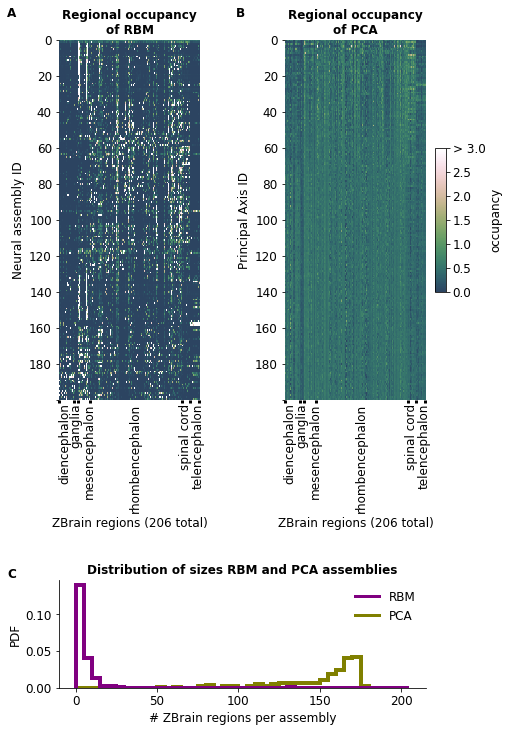

In [23]:
save_fig = False

fig = plt.figure(constrained_layout=False, figsize=[6, 10])
gs_matrix = fig.add_gridspec(ncols=2, nrows=1, bottom=0.45, top=0.95, 
                             hspace=0.6, wspace=0.6, left=0.05, right=0.9)
gs_stats = fig.add_gridspec(ncols=1, nrows=1, bottom=0.05, top=0.2, 
                             hspace=0.6, wspace=0.6, left=0.05, right=0.9)

ax_rbm_mat = fig.add_subplot(gs_matrix[0])
ax_pca_mat = fig.add_subplot(gs_matrix[1])
ax_spars = fig.add_subplot(gs_stats[0])

## RBM
cmap_matrix = sns.cubehelix_palette(start=.5, rot=-1, dark=0.25, light=1, reverse=True, as_cmap=True, n_colors=10)
hm = sns.heatmap(weighted_labels['rbm'][ol, :],
            cmap=cmap_matrix, 
            ax=ax_rbm_mat, vmax=3, 
            cbar=False)
ax_rbm_mat.set_ylabel('Neural assembly ID')
ax_rbm_mat.set_title('Regional occupancy\nof RBM', fontdict={'weight': 'bold'})
## PCA
sns.heatmap(weighted_labels['pca'], 
            cmap=cmap_matrix, 
            ax=ax_pca_mat, vmax=3,
            cbar=False)
ax_pca_mat.set_ylabel('Principal Axis ID')
ax_pca_mat.set_title('Regional occupancy\nof PCA', fontdict={'weight': 'bold'})

# labelling:
for ax in [ax_rbm_mat, ax_pca_mat]:
    ax.set_yticks(np.arange(11) * 20)
    ax.set_yticklabels([str(x * 20) for x in range(10)] + [''])
    
    ax.set_xticks(region_end_list, minor=False)  # minor: indicate ends of regions
    ax.set_xticks(region_middle_list, minor=True)  # major: used for region names 
    ax.set_xticklabels(region_divisions_nz_limits.keys(), fontdict={'ha': 'center'},
                       minor=True, rotation=90)
    ax.set_xticklabels(['' for x in region_end_list], minor=False)
    ax.tick_params(which='major', width=3, length=3, axis='x', pad=-70)
    ax.tick_params(which='minor', width=0, length=0, axis='x')
    ax.set_xlabel(f'ZBrain regions ({len(ind_regions)} total)')
    
## color bar 
ax_cbar = fig.add_axes([0.92, 0.6, 0.025, 0.2])  # left, bottom ,width, height
fig.colorbar(ax_rbm_mat.get_children()[0], cax=ax_cbar)
ax_cbar.set_ylabel('occupancy')
ax_cbar.yaxis.set_ticks(np.arange(7) * 0.5)
ax_cbar.set_yticklabels([str(x) for x in (np.arange(6) * 0.5)] + ['> 3.0'])

## Sparsity of regions
plot_bins = np.arange(0, len(ind_regions), 5)
for dr in plot_methods:
    #     plt.hist(sparsity_vector[dr], bins=plot_bins, label=dr)
    sns.distplot(sparsity_vector[dr], hist=True, kde=False, bins=plot_bins,
                 label=dr_legend[dr], color=dr_colors[dr], ax=ax_spars,
                 kde_kws={'linewidth': 4}, hist_kws={'histtype':'step', 'linewidth':4, 'alpha':1, 'density':True})  # prev alpha 0.7 lw 2
ax_spars.set_xlabel('# ZBrain regions per assembly'); 
ax_spars.set_ylabel('PDF'); 
ax_spars.set_title('Distribution of sizes RBM and PCA assemblies', fontdict={'weight': 'bold'});
ax_spars.spines['top'].set_visible(False)
ax_spars.spines['right'].set_visible(False)
handle_dict = {dr: matplotlib.lines.Line2D([], [], c=dr_colors[dr]) for dr in ['rbm', 'pca']}
ax_spars.legend(handles=[handle_dict['rbm'], handle_dict['pca']],
                labels=[dr_legend['rbm'], dr_legend['pca']],
                frameon=False, loc='upper right');

ax_spars.text(s='A', x=-42, y=0.913, fontdict={'weight': 'bold'})
ax_spars.text(s='B', x=98.4, y=0.913, fontdict={'weight': 'bold'})
ax_spars.text(s='C', x=-42, y=0.15, fontdict={'weight': 'bold'})

if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/fig_region_sparsity.pdf', bbox_inches='tight')

In [123]:
## Uniformity of connectivity:

## Original metric:
# w_th_arr, curve_NVUgeqKw, sh_curve_NVUgeqKw = {}, {}, {}
# print(f'Methods: {plot_methods}')
# for dr in plot_methods:
#     print(f'calculating {dr}')
#     w_th_arr[dr], curve_NVUgeqKw[dr], sh_curve_NVUgeqKw[dr] = af.count_connections(weight_matrix=weights[dr],
#                                                                                 n_w_th=250, perc_top=100)

## New metric:
# all_w_arrs, all_sh_w_arrs, all_cdfs, all_sh_cdfs = {}, {}, {}, {}
degree_distr, sh_degree_distr = {}, {}
print(f'Methods: {plot_methods}')
for dr in plot_methods:
#     print(f'calculating {dr}')
#     all_w_arrs[dr], all_sh_w_arrs[dr], all_cdfs[dr], all_sh_cdfs[dr] = af.count_connections_3(weight_matrix=weights[dr],
#                                                                                 n_w_th=250)

    degree_distr[dr], sh_degree_distr[dr] = af.count_connections_3(weight_matrix=weights[dr])

Methods: ['pca', 'rbm']


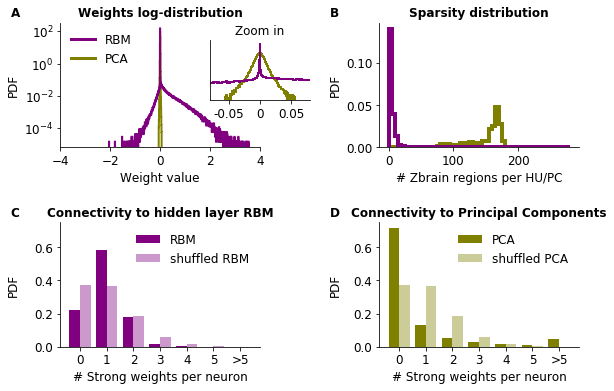

In [27]:
plt.rcParams['figure.figsize'] = (8, 5)
save_fig = False

fig = plt.figure(constrained_layout=False)
gs_stats = fig.add_gridspec(ncols=2, nrows=2, bottom=0.05, top=0.95, 
                         hspace=0.6, wspace=0.6, left=0.05, right=0.95) 


## Sparsity of regions
ax_spars = fig.add_subplot(gs_stats[1])
plot_bins = np.arange(0, len(ind_regions), 5)
for dr in plot_methods:
    #     plt.hist(sparsity_vector[dr], bins=plot_bins, label=dr)
    sns.distplot(sparsity_vector[dr], hist=True, kde=False, bins=plot_bins,
                 label=dr_legend[dr], color=dr_colors[dr], ax=ax_spars,
                 kde_kws={'linewidth': 4}, hist_kws={'histtype':'step', 'linewidth':4, 'alpha':1, 'density':True})  # prev alpha 0.7 lw 2
ax_spars.set_xlabel('# Zbrain regions per HU/PC'); 
ax_spars.set_ylabel('PDF'); 
ax_spars.set_title('Sparsity distribution', fontdict={'weight': 'bold'});
ax_spars.spines['top'].set_visible(False)
ax_spars.spines['right'].set_visible(False)

## Weights distribution
ax_mainw = fig.add_subplot(gs_stats[0])
plot_bins = np.linspace(np.min([weights[x].min() for x in weights.keys()]), 
                        np.max([weights[x].max() for x in weights.keys()]), 1000)
for dr in plot_methods:
    ax_mainw.hist(np.ravel(weights[dr]), bins=plot_bins, histtype='step', label=dr_legend[dr],
             density=True, linewidth=2, color=dr_colors[dr])
ax_mainw.set_yscale('log'); ax_mainw.set_xlabel('Weight value'); 
ax_mainw.set_ylabel('PDF'); 
ax_mainw.set_title('Weights log-distribution', fontdict={'weight': 'bold'})
ax_mainw.set_xlim([-4, 4])
ax_mainw.spines['top'].set_visible(False)
ax_mainw.spines['right'].set_visible(False)
handle_dict = {dr: matplotlib.lines.Line2D([], [], c=dr_colors[dr]) for dr in ['rbm', 'pca']}
ax_mainw.legend(handles=[handle_dict['rbm'], handle_dict['pca']],
                labels=[dr_legend['rbm'], dr_legend['pca']],
                frameon=False, loc='upper left');

## Weights distribution Zoom inset
ax_zoomw = ax_mainw.inset_axes([0.75, 0.38, 0.5, 0.48])
for dr in plot_methods:
    ax_zoomw.hist(np.ravel(weights[dr]), bins=np.linspace(-0.11, 0.11, 500), 
                  histtype='step', label=dr_legend[dr],
                  density=True, linewidth=2, color=dr_colors[dr])
ax_zoomw.get_yaxis().set_visible(False);
ax_zoomw.get_xaxis().set_ticklabels(['', '-0.05', '0', '0.05'])
ax_zoomw.set_yscale('log'); ax_zoomw.set_xlim([-0.08, 0.08]); 
ax_zoomw.set_ylim([1e-4, 5e3])
ax_zoomw.set_title('Zoom in')
ax_zoomw.spines['top'].set_visible(False)
ax_zoomw.spines['right'].set_visible(False)

## Uniformity plots
ax_unif = {}
for i_dr, dr in enumerate(['rbm', 'pca']):
    ax_unif[dr] = fig.add_subplot(gs_stats[2 + i_dr])
    pf.plot_degree_distr(degree_dict=degree_distr, degree_dict_sh=sh_degree_distr,
                         dr=dr, ax=ax_unif[dr], cutoff=6, normalise=True)
    ax_unif[dr].set_ylim([0, 0.75])
ax_unif['pca'].set_title('Connectivity to Principal Components', 
                         fontdict={'weight': 'bold'})

##  Alignment
fig.align_ylabels(axs=[ax_mainw, ax_unif['rbm']])
fig.align_ylabels(axs=[ax_spars, ax_unif['pca']])
fig.align_xlabels(axs=[ax_spars, ax_mainw])
fig.align_xlabels(axs=[ax_unif['rbm'], ax_unif['pca']])

ax_mainw.annotate(s='A', xycoords='axes fraction', xy=(-0.25, 1.05), 
                  fontweight='bold')
ax_spars.annotate(s='B', xycoords='axes fraction', xy=(-0.25, 1.05), 
                  fontweight='bold')
ax_unif['rbm'].annotate(s='C', xycoords='axes fraction', xy=(-0.25, 1.05), 
                  fontweight='bold')
ax_unif['pca'].annotate(s='D', xycoords='axes fraction', xy=(-0.25, 1.05), 
                  fontweight='bold')

if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/fig_hu_structure_stats.pdf', bbox_inches='tight')

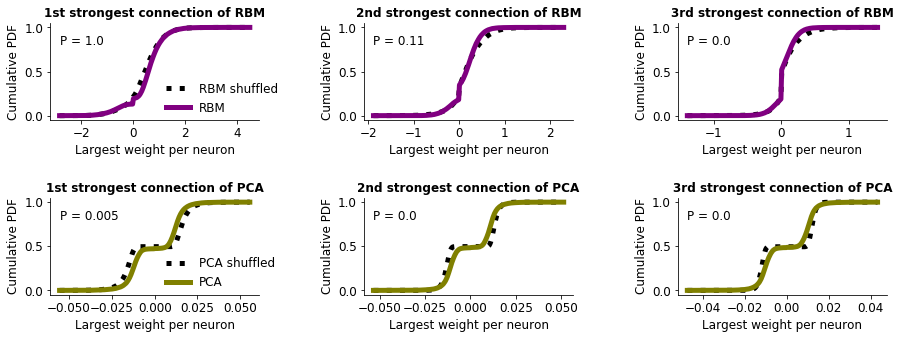

In [239]:
# ## Supplemental figure of uniform
# for dr in plot_methods:
#     for kk in range(all_cdfs[dr].shape[0]):
#         distr = all_cdfs[dr][kk, :]
#         sh_distr = all_sh_cdfs[dr][kk, :]
#         print(f'{dr}: K = {kk} P value = {np.round(scipy.stats.ks_2samp(distr, sh_distr)[1], 3)}')


# plt.rcParams['figure.figsize'] = (15, 5)
# plt.subplots_adjust(hspace=0.8, wspace=0.5)
# ax_unif_dict = {}
# dict_str_number = {0: '1st', 1: '2nd', 2: '3rd'}
# for i_dr, dr in enumerate(['rbm', 'pca']):
#     for i_k, k_value in enumerate([0, 1, 2]):
#         i_plot = 1 + i_k + (3 * i_dr)
#         ax_unif_dict[i_plot] = plt.subplot(2, 3, i_plot)
#         _ = pf.plot_uniform_distr(w_mat=all_w_arrs, sh_w_mat=all_sh_w_arrs,
#                                   cdf_mat=all_cdfs, sh_cdf_mat=all_sh_cdfs,
#                                   k_value=k_value, dr=dr, print_pval=True,
#                                   plot_legend=(i_k == 0), ax=ax_unif_dict[i_plot])

# DYNAMICS

In [340]:
hu_act_test = np.transpose(RBM.mean_hiddens(test_data['wb'].T))
ol = af.opt_leaf(hu_act_test)
reverse_ol = np.zeros_like(ol)
for i_new, i_old in enumerate(ol):
    reverse_ol[i_old] = i_new
hu_act_test_remap = hu_act_test[ol, :]

In [364]:
freq = 1 / np.mean(np.diff(rec.time))
print(f'frequency = {freq}')
# median_hu_period = af.compute_median_state_occupancy(activity=hu_act_test_remap, freq=freq)
median_vu_period = af.compute_median_state_occupancy(activity=test_data['wb'], 
                                                     bimodality=0.5, freq=freq)  # compute period of (neuron) binary data

(median_silence_duration, median_burst_duration, median_period_duration, 
 count_bursts) = af.compute_median_discretised_state_occupancy(activity_mat=hu_act_test_remap, 
                                                               frequency=freq, margin=0.4)  # compute period of HUs

## demean HU activity by using average between its 2 peaks (foudn by GMM)
hu_activity_effectively_demeaned = hu_act_test_remap.copy()
for mu in range(hu_act_test_remap.shape[0]):
    gmm = GaussianMixture(n_components=2).fit(hu_act_test_remap[mu, :, np.newaxis])
    two_peaks = gmm.means_[:2]
    effective_mean = two_peaks.mean()
    hu_activity_effectively_demeaned[mu, :] -= effective_mean

frequency = 3.3003290254073083
Number of units: 200


In [354]:
reverse_ol[159]
# ol[78]

157

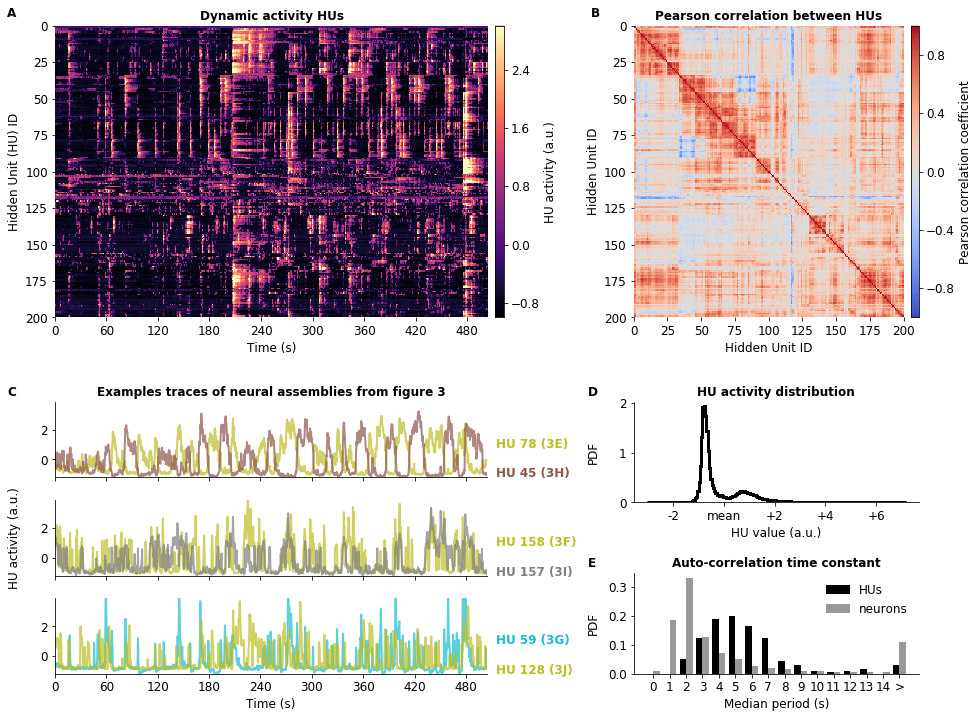

In [366]:
plt.rcParams['figure.figsize'] = (12, 9)
save_fig = False

fig = plt.figure(constrained_layout=False)
gs = {}
gs[0] = fig.add_gridspec(ncols=1, nrows=1, bottom=0.55, top=1, left=0, right=0.52)  # old format: top=0.28; bottom=0.45
gs[1] = fig.add_gridspec(ncols=1, nrows=1, bottom=0.55, top=1, left=0.67, right=1)
gs[2] = fig.add_gridspec(ncols=1, nrows=3, bottom=0, top=0.42, left=0, right=0.50, hspace=0.3)
gs[3] = fig.add_gridspec(ncols=1, nrows=2, bottom=0, top=0.42, left=0.67, right=1, hspace=0.7)

## Dynamic activity raster plot
ax_raster = fig.add_subplot(gs[0][0])
sns.heatmap(hu_activity_effectively_demeaned, vmin=-1, vmax=3, 
            cbar=False, cmap='magma', ax=ax_raster)
ax_raster.set_yticks([x * 25 for x in range(9)])
ax_raster.set_yticklabels(ax_raster.get_yticks())
ax_raster.set_xticks([x * int(60 * freq) for x in range(9)])
ax_raster.set_xticklabels((np.round(ax_raster.get_xticks() / freq)).astype('int'),
                          rotation=0)
ax_raster.set_xlabel('Time (s)'); ax_raster.set_ylabel('Hidden Unit (HU) ID')
divider = make_axes_locatable(ax_raster)
cax_rast = divider.append_axes('right', size='2%', pad=0.1)
mpl_colorbar(ax_raster.get_children()[0], cax=cax_rast)
cax_rast.yaxis.set_ticks_position('right')
cax_rast.set_ylabel(r'HU activity (a.u.)')
ax_raster.set_title('Dynamic activity HUs', fontdict={'weight': 'bold'})

## Pearson correlation plot
ax_corr = fig.add_subplot(gs[1][0])
corr_mat_hus = np.corrcoef(hu_activity_effectively_demeaned)
sns.heatmap(corr_mat_hus, cmap='coolwarm', cbar=False, ax=ax_corr, vmin=-1, vmax=1)
ax_corr.set_title('Pearson correlation between HUs', fontdict={'weight': 'bold'})
ax_corr.set_xlabel('Hidden Unit ID'); ax_corr.set_ylabel('Hidden Unit ID');
ax_corr.set_xticks([x * 25 for x in range(9)])
ax_corr.set_xticklabels(ax_raster.get_yticks(), rotation=0)
ax_corr.set_yticks([x * 25 for x in range(9)])
ax_corr.set_yticklabels(ax_raster.get_yticks())
divider = make_axes_locatable(ax_corr)
cax_corr = divider.append_axes('right', size='3%', pad=0.1)
mpl_colorbar(ax_corr.get_children()[0], cax=cax_corr)
cax_corr.yaxis.set_ticks_position('right')
cax_corr.set_ylabel(r'Pearson correlation coefficient')

## Example traces:
mu_plot_dict = {0: (78, 45), 1: (158, 157), 2: (59, 128)}
mu_colour_dict = {k: color_cycle[k % 10] for k in range(200)}
fig_3_label_dict = {78: 'E', 45: 'H', 158: 'F', 157: 'I', 59: 'G', 128: 'J'}
ax_examples = {}
for i_plot, mu_list in mu_plot_dict.items():
    ax_examples[i_plot] = fig.add_subplot(gs[2][i_plot])
    for mu in mu_list:
        ax_examples[i_plot].plot(hu_activity_effectively_demeaned[mu, :], linewidth=2,
                                 c=mu_colour_dict[mu], alpha=0.7)
    ax_examples[i_plot].spines['top'].set_visible(False)
    ax_examples[i_plot].spines['right'].set_visible(False)
    ax_examples[i_plot].set_xticks([x * int(60 * freq) for x in range(9)])
    ax_examples[i_plot].margins(x=0)
    ax_examples[i_plot].set_ylim([-1.2, 3.9])
    ax_examples[i_plot].text(s=f'HU {mu_list[0]} (3{fig_3_label_dict[mu_list[0]]})', x=1700, y=0.8,
                             fontdict={'color': mu_colour_dict[mu_list[0]], 'weight': 'bold'})
    ax_examples[i_plot].text(s=f'HU {mu_list[1]} (3{fig_3_label_dict[mu_list[1]]})', x=1700, y=-1.2, 
                             fontdict={'color': mu_colour_dict[mu_list[1]], 'weight': 'bold'})
    if i_plot == 2:
        ax_examples[i_plot].set_xticklabels((np.round(ax_raster.get_xticks() / freq)).astype('int'),
                                  rotation=0)
    else:
        ax_examples[i_plot].set_xticklabels([])
ax_examples[0].set_title('Examples traces of neural assemblies from figure 3', fontdict={'weight': 'bold'})
ax_examples[1].set_ylabel('HU activity (a.u.)')
ax_examples[2].set_xlabel('Time (s)'); #ax_raster.set_ylabel('Hidden Unit (HU) ID')

## Distirbution of HU activity
ax_hist_act = fig.add_subplot(gs[3][0])
ax_hist_act.hist(hu_activity_effectively_demeaned.flatten(), bins=200, histtype='step', 
                 linewidth=3, color='k', density=True);
ax_hist_act.set_xlabel('HU value (a.u.)'); ax_hist_act.set_ylabel('PDF');
ax_hist_act.set_title('HU activity distribution', weight='bold')
ax_hist_act.set_xticks([-2, 0 , 2, 4, 6])
ax_hist_act.set_xticklabels(['-2', 'mean', '+2', '+4', '+6'])
ax_hist_act.spines['right'].set_visible(False)
ax_hist_act.spines['top'].set_visible(False)

##
# ax_hist_reside_main = fig.add_subplot(gs[2][1])
# # fract_geq0 = (hu_act_test_remap >= 0).mean(1)  # fraction of time points where value >= 0 for each hu
# # fract_main = np.abs(fract_geq0 - 0.5) + 0.5  # mirror at 0.5 for all points below 0.5
# ax_hist_reside_main.hist(fract_main * 100, bins=20, linewidth=3,# histtype='step',
#                          color='k', density=True, rwidth=0.8)
# ax_hist_reside_main.set_xlabel('Time in main mode (%)')
# ax_hist_reside_main.set_ylabel('PDF');
# ax_hist_reside_main.set_title('Distribution time in main mode', weight='bold')
# ax_hist_reside_main.set_xticks([x * 10 for x in range(5, 11)])
# ax_hist_reside_main.spines['right'].set_visible(False)
# ax_hist_reside_main.spines['top'].set_visible(False)
# ax_hist_reside_main.legend(['HUs'], loc='upper right', frameon=False)


ax_hist_inter_mainstate = fig.add_subplot(gs[3][1])
pf.plot_degree_distr(degree_dict_sh={'ea': median_vu_period.sum(1).round().astype('int')},
                     degree_dict={'ea': median_period_duration.round().astype('int')},
                     ax=ax_hist_inter_mainstate, plot_shuffled=True,
                     cutoff=15, normalise=True, dr='ea', colour='k',
                     label='HUs', label_sh='neurons', v_spacing_greater=True)

ax_hist_inter_mainstate.set_xlabel('Median period (s)')
ax_hist_inter_mainstate.set_ylabel('PDF')
ax_hist_inter_mainstate.set_title('Auto-correlation time constant', weight='bold')
ax_hist_inter_mainstate.spines['right'].set_visible(False)
ax_hist_inter_mainstate.spines['top'].set_visible(False)
ax_hist_inter_mainstate.legend(loc='upper right', frameon=False)

ax_raster.annotate(s='A', xycoords='axes fraction', xy=(-0.11, 1.03), 
                  fontweight='bold')
ax_corr.annotate(s='B', xycoords='axes fraction', xy=(-0.16, 1.03), 
                  fontweight='bold')
ax_hist_act.annotate(s='D', xycoords='axes fraction', xy=(-0.16, 1.06), 
                  fontweight='bold')
ax_examples[0].annotate(s='C', xycoords='axes fraction', xy=(-0.11, 1.07), 
                  fontweight='bold')
ax_hist_inter_mainstate.annotate(s='E', xycoords='axes fraction', xy=(-0.16, 1.06), 
                  fontweight='bold')
fig.align_ylabels(axs=[ax_corr, ax_hist_act, ax_hist_inter_mainstate])
fig.align_ylabels(axs=[ax_raster, ax_examples[0], ax_examples[1], ax_examples[2]])
fig.align_xlabels(axs=[ax_examples[2], ax_hist_inter_mainstate])
fig.align_xlabels(axs=[ax_raster, ax_corr])

if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/fig_dynamics_margin04.pdf', bbox_inches='tight')

## Jerome's autocorrelation

In [358]:
mu = 0

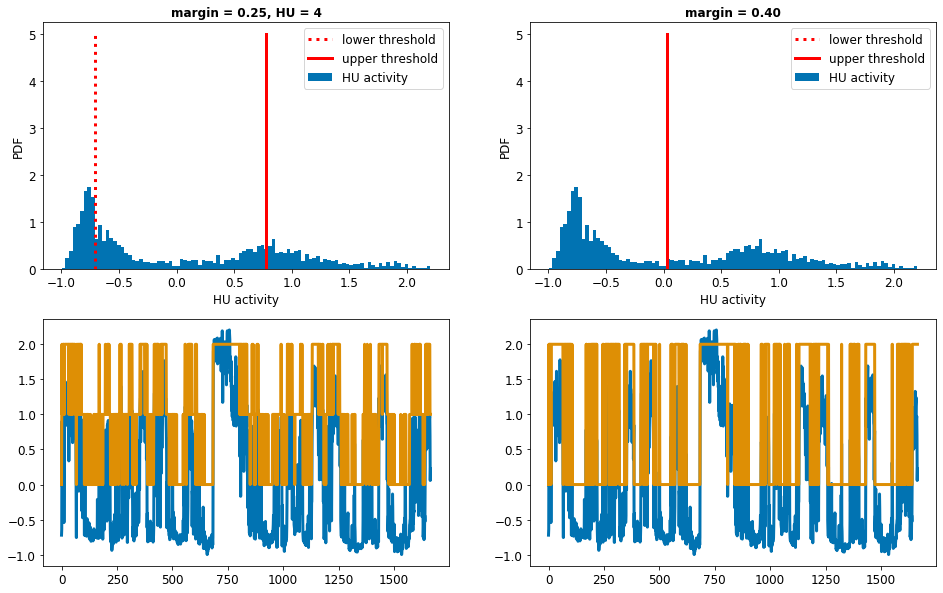

In [362]:
plt.rcParams['figure.figsize'] = (16, 10)
mu += 1
fig, axes = plt.subplots(2, 2)
tmp25 = af.discretize(hu_act_test_remap[mu, :], plot=True, margin=0, ax=axes[0, 0])
tmp40 = af.discretize(hu_act_test_remap[mu, :], plot=True, margin=0.5, ax=axes[0, 1])
axes[0, 0].set_title(f'margin = 0.25, HU = {mu}', fontdict={'weight': 'bold'})
axes[0, 1].set_title('margin = 0.40', fontdict={'weight': 'bold'})

axes[1, 0].plot(hu_act_test_remap[mu, :])
axes[1, 0].plot(tmp25)
axes[1, 1].plot(hu_act_test_remap[mu, :])
axes[1, 1].plot(tmp40);
# 0.25 bad for HUs: 3, 6, 11, 16, 18 (stopped after 20)
# 0.4 bit tight for HUs: 29, 56, 117

In [ ]:
# median_silence_duration, median_burst_duration, median_period_duration, count_bursts = af.compute_median_discretised_state_occupancy(activity_mat=hu_act_test_remap, frequency=freq, margin=0.25)


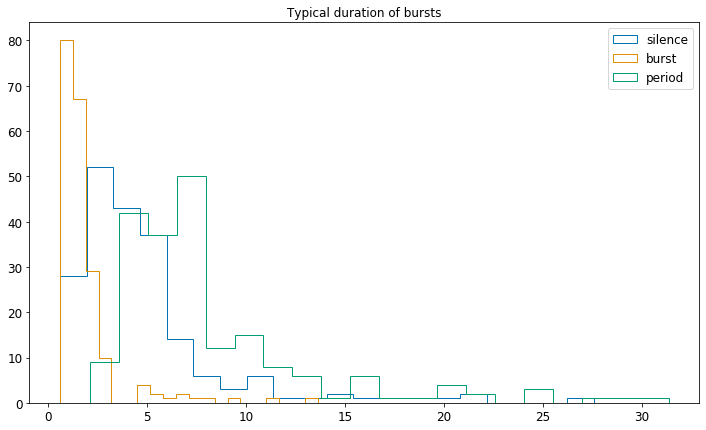

In [74]:
plt.hist(median_silence_duration / freq, bins=20, label='silence', histtype='step'); 
plt.hist(median_burst_duration  / freq, bins=20, label='burst', histtype='step');
plt.hist(median_period_duration  / freq, bins=20, histtype='step', label='period');
plt.title('Typical duration of bursts')
# plt.show()
plt.legend()

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


44, 0.589,0.138,0.273


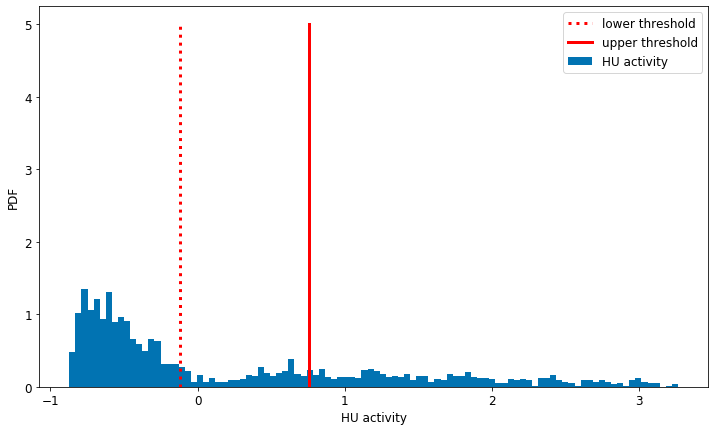

In [56]:
mu = np.argmax(median_burst_duration)

discrete_h = discretize(hu_act_test_remap[mu, :], margin=0.25,plot=True)
print('%s, %.3f,%.3f,%.3f'% (
    mu, 
    (discrete_h==0).mean(),
    (discrete_h==1).mean(),
    (discrete_h==2).mean()  )
     )

list_silence_durations,list_burst_durations = get_burst_and_silence_times(discrete_h)



# OLD stuff

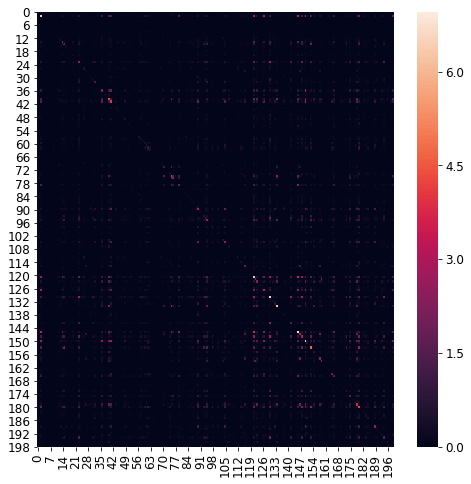

In [84]:
def adj_weights(weights):
    assert weights.shape[1] > weights.shape[0]
    tmp = np.abs(weights)
    mat = tmp.dot(tmp.T)
#     print(mat.shape)
    norm_els = np.diag(mat)
    norm_mat = norm_els[:, np.newaxis] + norm_els[np.newaxis, :]
    result = 2 * mat / norm_mat
#     np.fill_diagonal(result, 0.01)
    return result
    
def neurons_per_region_per_hu(RBM=RBM, rec=rec, mu=0, abs_th=0.05,
                              selection_neurons=selected_neurons['wb']):
    ## plot region occupancy
    hu_weights = RBM.weights[mu, :]
    vu_labels = rec.labels[selection_neurons, :]
    vu_selection = np.abs(hu_weights) >= abs_th  # VUs with weights absolute value geq threshold
    vu_selection_labels = vu_labels[vu_selection, :]  # their label
    n_vu_per_region_total = np.squeeze(np.array(vu_labels.sum(0)))  # total number of neurons per region
    n_vu_per_region = np.squeeze(np.array(vu_selection_labels.sum(0)))  # number of these neurons per region
    inds_nz = np.where(n_vu_per_region_total > 0)
    n_vu_per_region_normalised = n_vu_per_region
    n_vu_per_region_normalised[inds_nz] = n_vu_per_region[inds_nz] / n_vu_per_region_total[inds_nz]
    
    return n_vu_per_region, n_vu_per_region_normalised

region_occupancy_hus = np.zeros((RBM.weights.shape[0], rec.labels.shape[1]))
for mu in range(RBM.weights.shape[0]):
    _, region_occupancy_hus[mu, :] = neurons_per_region_per_hu(mu=mu)
adj_mat = np.dot(region_occupancy_hus, region_occupancy_hus.transpose())
# sns.heatmap(np.log(region_occupancy_hus + 1), cmap='Greys')

# adj_mat = adj_weights(RBM.weights[ol, :])

# plt.rcParams['figure.figsize'] = (8, 8)
sns.heatmap(adj_mat)
# plt.xlabel('# HU')
# plt.ylabel('# HU')
# plt.title('Log dot product between HUs');

In [80]:
adj_mat

array([[ 1.        ,  0.19453328, -0.04642224, ...,  0.38378943,
         0.02679237, -0.03724182],
       [ 0.19453328,  1.        , -0.06875138, ...,  0.15449964,
        -0.00776811, -0.01531467],
       [-0.04642224, -0.06875138,  1.        , ..., -0.06436475,
         0.00412454,  0.43714402],
       ...,
       [ 0.38378943,  0.15449964, -0.06436475, ...,  1.        ,
         0.04374877, -0.02130514],
       [ 0.02679237, -0.00776811,  0.00412454, ...,  0.04374877,
         1.        ,  0.11123294],
       [-0.03724182, -0.01531467,  0.43714402, ..., -0.02130514,
         0.11123294,  1.        ]])

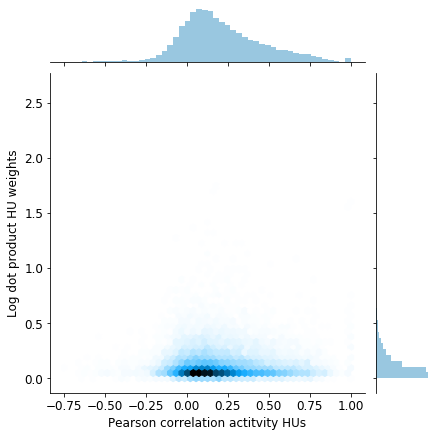

In [87]:

jp = sns.jointplot(corr_mat_hus.ravel(), np.sqrt(adj_mat.ravel()), kind='hex')
jp.set_axis_labels('Pearson correlation actitvity HUs', 
                   'Log dot product HU weights')

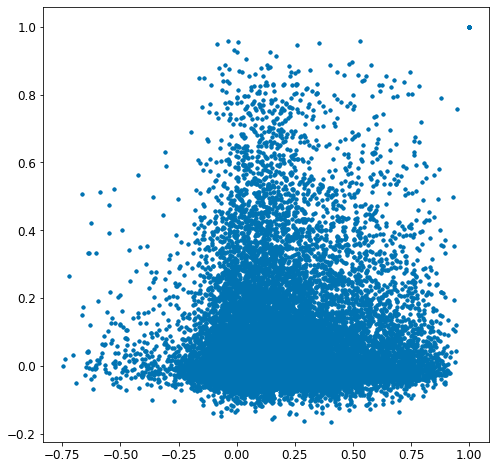

In [82]:
plt.plot(corr_mat_hus.ravel(), adj_mat.ravel(), '.')